In [131]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, accuracy_score,mean_squared_error
from sklearn.model_selection import train_test_split
from plotnine import *

# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `bill_depth_mm` using the other variables in the dataset.

**Dummify** all variables that require this.

In [132]:
from palmerpenguins import load_penguins
penguins = load_penguins()
penguins = penguins.dropna()
penguins["year"] = penguins["year"].astype("object")

penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


In [133]:
X = penguins.drop(['bill_depth_mm'],axis=1)
y = penguins["bill_depth_mm"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=1)

Let's use the other variables to predict `bill_depth_mm`. Prepare your data and fit the following models on the entire dataset:

* Your best multiple linear regression model from before
* Two kNN models (for different values of K)
* A decision tree model

Create a plot like the right plot of Fig 1. in our `Model Validation` chapter with the training and test error plotted for each of your four models.

Which of your models was best?

In [134]:
#Multiple Linear Regression

#Create Pipeline

ct = ColumnTransformer(
    transformers=[
        ("dummify", OneHotEncoder(sparse_output = False), ['species', 'sex', 'year']),
        ('Standardize', StandardScaler(), ['bill_length_mm', 'flipper_length_mm', 'body_mass_g']),
    ], remainder = "drop"
).set_output(transform = "pandas")


lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())
   ]
)

lr_pipeline_fitted = lr_pipeline_1.fit(X,y)

lr_ypred = lr_pipeline_fitted.predict(X_test)

lr_mse = mean_squared_error(y_test, lr_ypred)
lr_mse

0.5297147705078126

In [135]:
#KNN k = 2

#Create Pipeline

ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)), 
    ("standardize", StandardScaler(),make_column_selector(dtype_include=np.number)) 
  ],
  remainder = "passthrough"
)

knn_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("knn", KNeighborsRegressor(n_neighbors=2))
   ]
)

knn_pipeline_fitted = knn_pipeline_1.fit(X,y)

knn_ypred = knn_pipeline_fitted.predict(X_test)

knn_mse = mean_squared_error(y_test, knn_ypred)
knn_mse

0.26913750000000003

In [136]:
#KNN k = 7

#Create Pipeline

ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)), 
    ("standardize", StandardScaler(),make_column_selector(dtype_include=np.number)) 
  ],
  remainder = "passthrough"
)

knn_pipeline_2 = Pipeline(
  [("preprocessing", ct),
  ("knn", KNeighborsRegressor(n_neighbors=7))
   ]
)

knn_pipeline_fitted2 = knn_pipeline_2.fit(X,y)

knn_ypred2 = knn_pipeline_fitted2.predict(X_test)

knn2_mse = mean_squared_error(y_test, knn_ypred2)
knn2_mse

0.43326938775510226

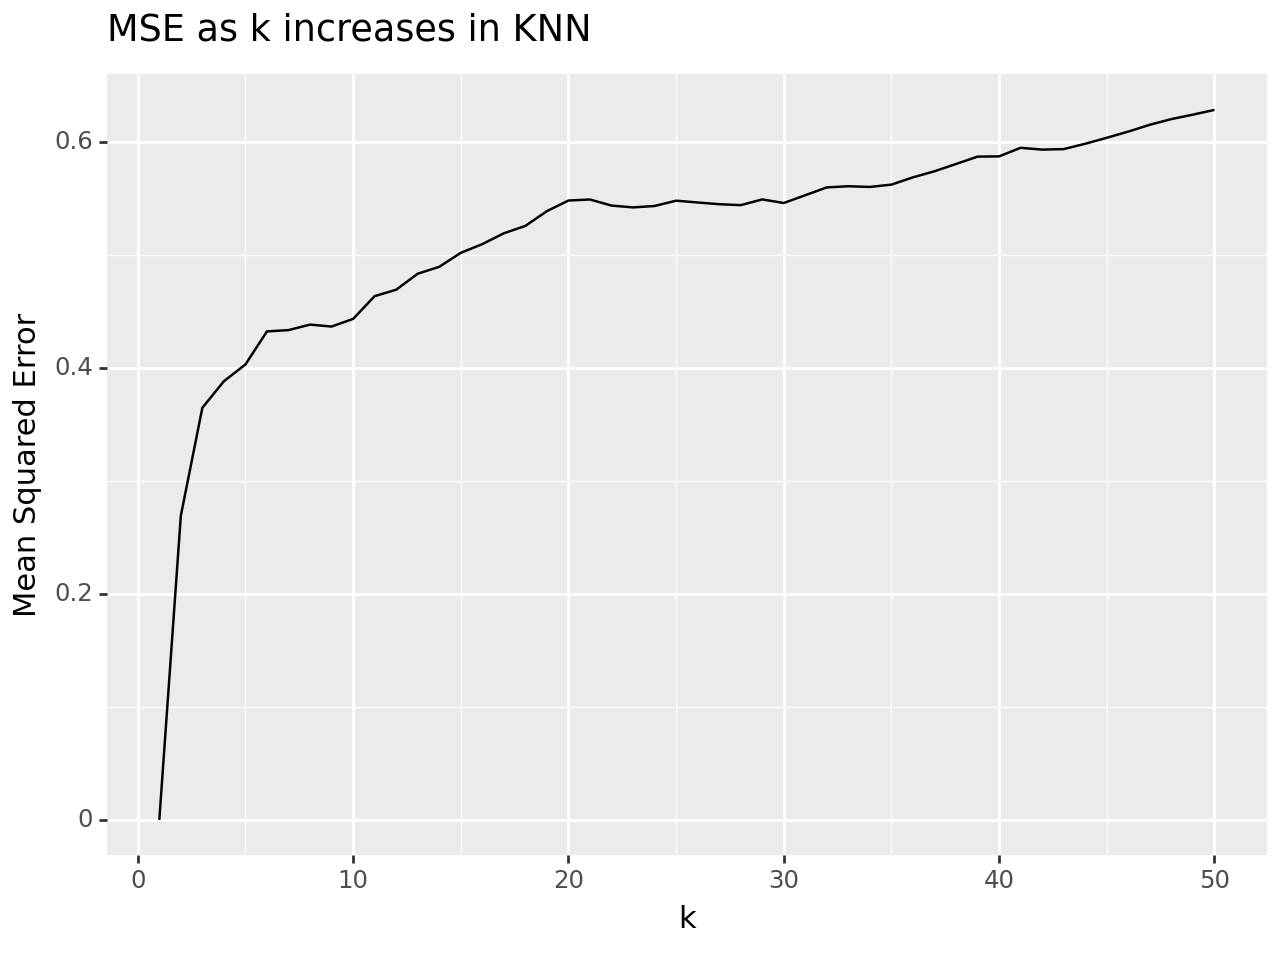

In [140]:
#Plot displaying how MSE increases as k increases

#Get range to iterate ocer
k_values = range(1, 51)  # For example, from 1 to 50

mse_results = []

for k in k_values:
    knn_pipeline = Pipeline([
        ("preprocessing", ct),
        ("DecisionTree", KNeighborsRegressor(n_neighbors=k))
    ])

    #Fit + predict
    knn_pipeline_fitted = knn_pipeline.fit(X, y)
    knn_ypred = knn_pipeline_fitted.predict(X_test)

    #Get mse's and append to list
    mse = mean_squared_error(y_test, knn_ypred)
    mse_results.append(mse)

# Create df to plot
results_df = pd.DataFrame({
    'k': k_values,
    'MSE': mse_results
})

# Plot
kplot = (ggplot(results_df, aes(x='k_values', y='MSE'))
        + geom_line()
        + labs(x='k', y='Mean Squared Error', title='MSE as k increases in KNN'))

print(kplot)


As k increases, the mse increases and the model becomes less overfit.

In [138]:
#Decision Trees

#Create Pipeline

ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)), 
    ("standardize", StandardScaler(),make_column_selector(dtype_include=np.number)) 
  ],
  remainder = "passthrough"
)

dt_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("DecisionTree", DecisionTreeRegressor(min_samples_leaf=50))
   ]
)

dt_pipeline_fitted = dt_pipeline_1.fit(X,y)

dt_ypred = dt_pipeline_fitted.predict(X_test)

dt_mse = mean_squared_error(y_test, dt_ypred)
dt_mse

0.6016086260268126

Similar to k increasing in knn, as min_samples_leaf increases, the mse increases as well.

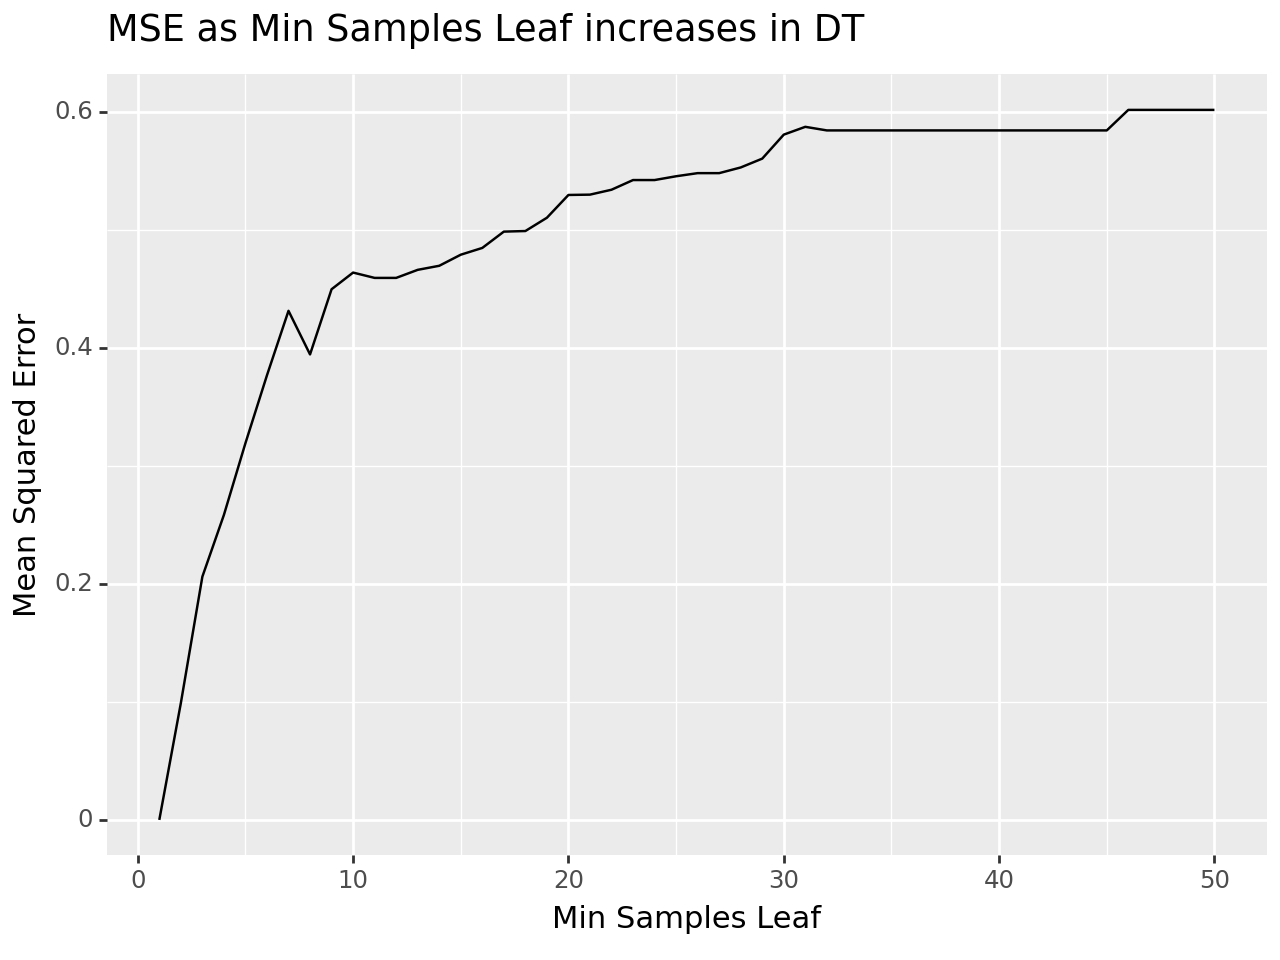

In [139]:
#Plot displaying how MSE increases as min_samples_leaf increases

#Get range to iterate ocer
min_samples_leaf_values = range(1, 51)  # For example, from 1 to 50

mse_results = []

for min_samples_leaf in min_samples_leaf_values:
    dt_pipeline = Pipeline([
        ("preprocessing", ct),
        ("DecisionTree", DecisionTreeRegressor(min_samples_leaf=min_samples_leaf))
    ])

    #Fit + predict
    dt_pipeline_fitted = dt_pipeline.fit(X, y)
    dt_ypred = dt_pipeline_fitted.predict(X_test)

    #Get mse's and append to list
    mse = mean_squared_error(y_test, dt_ypred)
    mse_results.append(mse)

# Create df to plot
results_df = pd.DataFrame({
    'min_samples_leaf': min_samples_leaf_values,
    'MSE': mse_results
})

# Plot
dtplot = (ggplot(results_df, aes(x='min_samples_leaf', y='MSE'))
        + geom_line()
        + labs(x='Min Samples Leaf', y='Mean Squared Error', title='MSE as Min Samples Leaf increases in DT'))

print(dtplot)
